### Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import re
import tqdm
from preprocessing import Players, Seasons
from features import Features
from sklearn.model_selection import GridSearchCV

pd.set_option('max_columns', None)

db_name = 'postgres'
db_hostname = 'localhost'
db_user = 'postgres'
db_password = 'tttBBB777'
db_table = 'players_list'

engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_hostname}/{db_name}')

In [2]:
season = pd.read_sql('select * from player_season', engine)
players = pd.read_sql('select * from player', engine)

### Препроцессинг

In [3]:
season_stats = Seasons.preprocess(season)
players = Players.preprocess(players)

### Подготовка фич

In [4]:
features = Features(players, season_stats)
features_df = features.gather_all_features()
features_df.rename(columns = lambda x: x.replace('/', '_'), inplace=True)
features_df = features_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

Gathering league ratings...
Gathering age...
Gathering nationalities...


  0%|                                                   | 0/11 [00:00<?, ?it/s]

Gathering positions...


100%|██████████████████████████████████████████| 11/11 [00:37<00:00,  3.38s/it]


Gathering dummies...
Gathering per-game stats...
Gathering lags stats...


100%|████████████████████████████████████████████| 3/3 [00:08<00:00,  2.68s/it]


Gathering aggregates...


100%|███████████████████████████████████████████| 4/4 [10:29<00:00, 157.35s/it]


#### Складываем данные которые нам в будущем понадобятся в базу

In [5]:
from prepare_data_for_db import copy_df

copy_df(features_df, 'features', engine, if_exists='replace')

rating = features_df[features_df['draft_entry'].isnull() == False].league.value_counts().reset_index()
rating.columns = ['league', 'league_rating']
rating.to_sql('league_rating', index=False, con=engine, if_exists='replace')

#### Приводим в порядок колонки

In [6]:
non_features = ['season', 'team', 'league', 'player_id', 'year', 'name', 'id', 'position', 'age', 'nation', 'shoots', 'youthteam', 'date_of_birth', 
                'birth_country', 'birth_city', 'nhl_rights', 'draft_team', 'nation_', 'points', 'penalty', 'plus_minus', 'goals_per_game', 
                'assists_per_game', 'points_per_game', 'penalty_per_game', 'plus_minus_per_game']

targets = ['goals', 'assists']

# Для правильного сплита - сортируем по возрастанию сезона
features_df = features_df[(features_df[targets[0]].isnull() == False) & (features_df[targets[1]].isnull() == False)].sort_values(['season', 'postseason_flag']).reset_index(drop=True)
features_df.drop(non_features, axis=1, inplace=True)

### Построение модели

In [7]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [9]:
sample_n = int(features_df.shape[0]*0.05) 
features_df_sample = features_df.sample(sample_n).reset_index().sort_values('index').set_index('index')

In [10]:
X_sample = features_df_sample[[x for x in features_df_sample.columns if x not in targets]]
X = features_df[[x for x in features_df.columns if x not in targets]]

tscv = TimeSeriesSplit(n_splits=4)

In [11]:
grid = {'num_leaves': [15, 25, 50],
        'max_depth': [4, 10, 16],
        'min_child_samples': [5, 30, 60],
        'min_child_weight': [1e-2, 1, 1e2],
        'subsample': [0.8, 0.4],
        'colsample_bytree': [0.8, 0.4],
        'reg_alpha': [1, 10, 100],
        'reg_lambda': [1, 10, 100]}

In [18]:
scores = {}
parameters = {}

for target in targets:
    gbm = LGBMRegressor()
    y_sample = features_df_sample[target]
    y = features_df[target]
    
    scores[target] = []
    
    gscv = GridSearchCV(gbm, grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
    params = gscv.fit(X_sample, y_sample).best_params_
    parameters[target] = params
    gbm = gbm.set_params(**params)
    
    for train_index, test_index in tqdm.tqdm(tscv.split(X), total=tscv.n_splits):
        model = gbm.fit(X.loc[train_index], y.loc[train_index])
        prediction = model.predict(X.loc[test_index])
        scores[target].append(mean_absolute_error(y.loc[test_index], prediction))

100%|████████████████████████████████████████████| 4/4 [01:43<00:00, 25.80s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 2916 candidates, totalling 11664 fits


[Parallel(n_jobs=1)]: Done 11664 out of 11664 | elapsed: 330.1min finished
100%|████████████████████████████████████████████| 4/4 [01:47<00:00, 26.86s/it]


In [20]:
parameters

{'goals': {'colsample_bytree': 0.8,
  'max_depth': 16,
  'min_child_samples': 5,
  'min_child_weight': 0.01,
  'num_leaves': 50,
  'reg_alpha': 100,
  'reg_lambda': 1,
  'subsample': 0.8},
 'assists': {'colsample_bytree': 0.8,
  'max_depth': 10,
  'min_child_samples': 30,
  'min_child_weight': 0.01,
  'num_leaves': 50,
  'reg_alpha': 100,
  'reg_lambda': 1,
  'subsample': 0.8}}

In [21]:
import joblib

joblib.dump(X.columns, f'source/features.pkl')

for target in targets:
    y = features_df[target]
    gbm = LGBMRegressor()
    gbm.set_params(**parameters[target])
    model = gbm.fit(X, y)
    joblib.dump(model, f'source/model_{target}.pkl')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

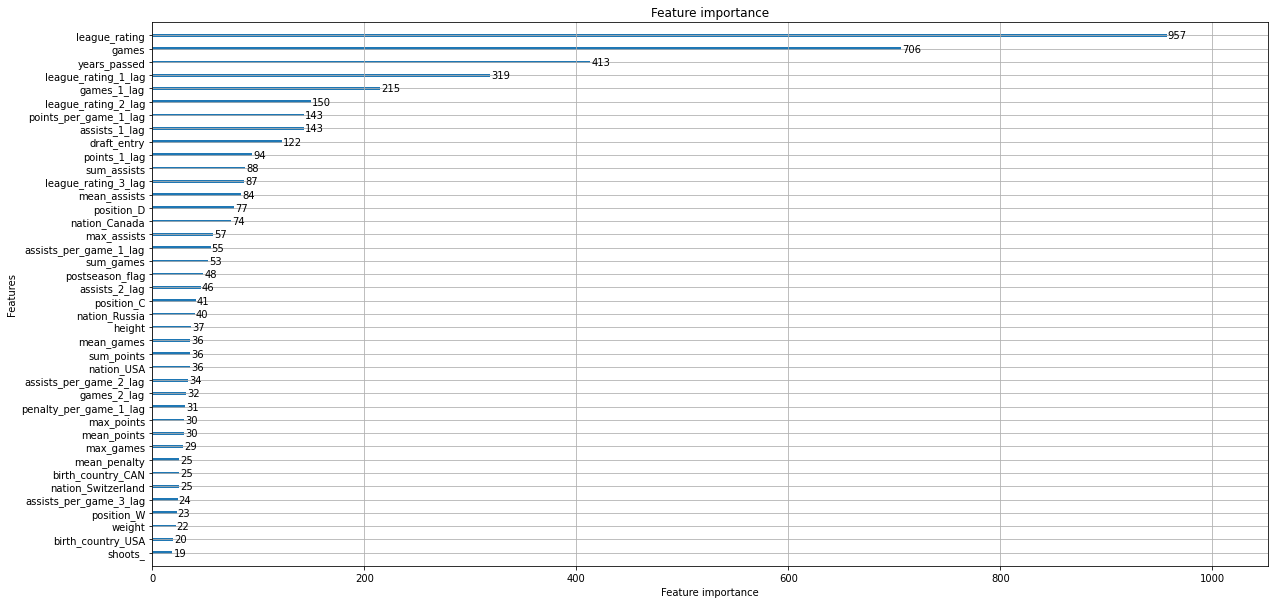

In [22]:
plot_importance(model, max_num_features=40, figsize=(20, 10))